# 02 - Data from the Web

In [158]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup as bs
import json
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.import seaborn as sns

## Useful functions

In [8]:
with open('domains') as file:
    domains_list = sorted(list(line.strip() for line in file),key = lambda s: -len(s))

def clean_number(n):
    return int(''.join(filter(lambda c: c.isdigit(), n)))

def find_domain(url):
    for domain in domains_list:
        if url.endswith(domain):
            return domain

def clean_url(url):
    url = re.sub('https?://(www.)?','', url)
    url = re.sub(r'([^/]+).*',r'\1', url)
    domain = find_domain(url)
    url = re.sub(r'[a-zA-Z]+\.([a-zA-Z]+.' + domain +r')', r'\1', url)
    return url

def select_or_zero(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_number(selection[0].text)

def select_url(soup, select):
    selection = soup.select(select)
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def normalize_name(name):
    name = str(name)
    name = re.sub('\(.*\)','', name)
    name = re.sub('^The','', name)
    name = re.sub('^É','E', name)
    name = name.replace('–', '-')
#     name = name.title().replace('Eth Zurich - Swiss Federal Institute Of Technology Zurich', 'Eth Zurich - Swiss Federal Institute Of Technology')
#     name = name.replace('Freie Universitaet', 'Free University Of')
    return name.title().strip()

## Top Universities

In [10]:
def get_stats(directory):
    res = get('https://www.topuniversities.com'+directory)
    soup = bs(res.text, "lxml")
    faculty_total = select_or_zero(soup, '.total .text .number')
    faculty_inter = select_or_zero(soup, '.inter .text .number')
    student_total = select_or_zero(soup, '.student .number')
    student_inter = select_or_zero(soup, '.inter .progress-bar-info .number')
    uni_url = select_url(soup, '.school-site')
    return faculty_total, faculty_inter, student_total, student_inter, uni_url

def prepare_uni_data_tu(uni):
    uni_infos = dict()
    uni_infos['Name'] = normalize_name(uni['title'])
    uni_infos['Rank Top Universities'] = clean_number(uni['rank_display'])
    uni_infos['Country'] = uni['country'].strip()
    uni_infos['Region'] = uni['region'].strip()
    uni_infos['Total faculty members'], \
    uni_infos['International faculty members'], \
    uni_infos['Total students'], \
    uni_infos['International students'], \
    uni_infos['url_tu'] = get_stats(uni['url'])
    return uni_infos

res = get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508338164061', 'html')
json_ranking_tu = json.loads(res.text)['data']
json_ranking_tu_top = sorted(json_ranking_tu, key=lambda k: clean_number(k['rank_display']))[:200]
df_tu = pd.DataFrame(list(map(prepare_uni_data_tu,json_ranking_tu_top)))

KeyboardInterrupt: 

In [69]:
#df_tu.to_pickle('df_tu.xz')
df_tu = pd.read_pickle('df_tu.xz')

In [70]:
df_tu['Name'] = df_tu['Name'].apply(normalize_name)
df_tu['Name'].apply(normalize_name)
df_tu

,Country,International faculty members,International students,Name,Rank Top Universities,Region,Total faculty members,Total students,url_tu
0,United States,1679.0,3717.0,Massachusetts Institute Of Technology,1,North America,2982.0,11067.0,NaN
1,United States,2042.0,3611.0,Stanford University,2,North America,4285.0,15878.0,NaN
2,United States,1311.0,5266.0,Harvard University,3,North America,4350.0,22429.0,NaN
3,United States,350.0,647.0,California Institute Of Technology,4,North America,953.0,2255.0,NaN
4,United Kingdom,2278.0,6699.0,University Of Cambridge,5,Europe,5490.0,18770.0,NaN
5,United Kingdom,2964.0,7353.0,University Of Oxford,6,Europe,6750.0,19720.0,NaN
6,United Kingdom,2554.0,14854.0,Ucl,7,Europe,6345.0,31080.0,ucl.ac.uk
7,United Kingdom,2071.0,8746.0,Imperial College London,8,Europe,3930.0,16090.0,imperial.ac.uk
8,United States,635.0,3379.0,University Of Chicago,9,North America,2449.0,13557.0,NaN
9,Switzerland,1886.0,7563.0,Eth Zurich - Swiss Federal Institute Of Techno...,10,Europe,2477.0,19815.0,NaN


In [239]:
def sort(df, column_nominator, column_denominator, column_name):
    df_temp = df.copy()
    df_temp[column_name] = df_temp[column_nominator]/df_temp[column_denominator]
    df_sorted = df_temp.sort_values(by=[column_name], ascending=False)
    return df_sorted

def group(df, grouping_column):
    df_temp = df.copy()
    df_grouped = df_temp.groupby([grouping_column])
    df_aggregated = df_grouped.sum()
    return df_aggregated

def plot(df, x, y, xlabel, ylabel):
    barchart = df.plot.bar(x=x, y=y)
    barchart.set_xlabel(xlabel)
    barchart.set_ylabel(ylabel)
    plt.show()

def reduced_plot(df, x, y, xlabel, ylabel):
    reduced_index = np.arange(10)
    reduced_df = df.take(index)
    plot(reduced_df, x, y, xlabel, ylabel)

In [296]:
#column index
name = 'Name'
total_faculty_members = 'Total faculty members'
total_students = 'Total students'
international_students = 'International students'
total_students = 'Total students'
faculty_members_students_ratio = 'Ratio faculty members/students'
international_students_ratio = 'Ratio international students'
country = 'Country'
region = 'Region'
students_staff_ratio ='Student/Staff Ratio'
pc_international_students = '% of International Students'
number_international_students = 'Number of International Students'
number_students = 'Number of Students'
#x- and y- labels
university_name = 'University name'

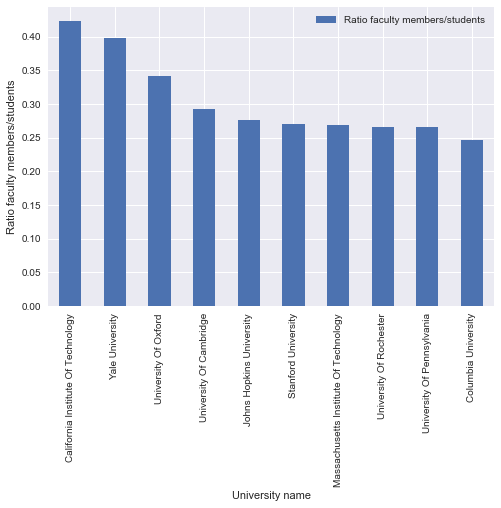

In [244]:
df_tu_QA = sort(df_tu, total_faculty_members, total_students, faculty_members_students_ratio)
reduced_plot(df_tu_QA, name, faculty_members_students_ratio, university_name, faculty_members_students_ratio)

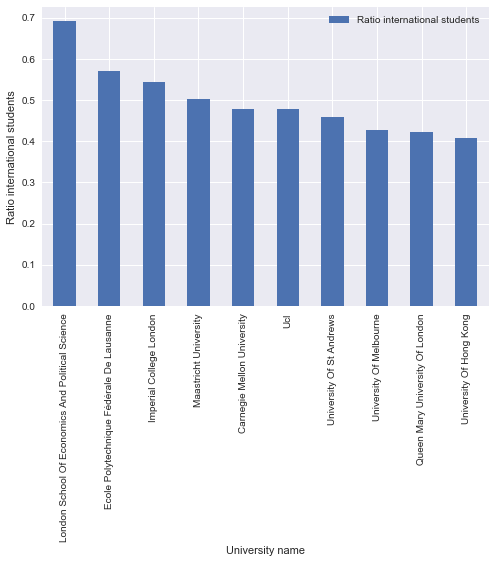

In [261]:
df_tu_QB = sort(df_tu, international_students, total_students, international_students_ratio)
reduced_plot(df_tu_QB, name, international_students_ratio, university_name, international_students_ratio)

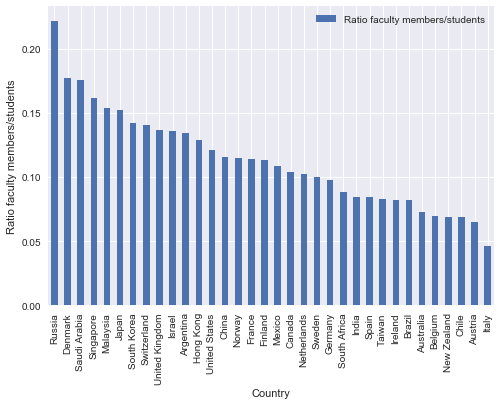

In [268]:
df_tu_country = group(df_tu, country)
df_tu_QAC = sort(df_tu_country, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAC, country, faculty_members_students_ratio, country, faculty_members_students_ratio)

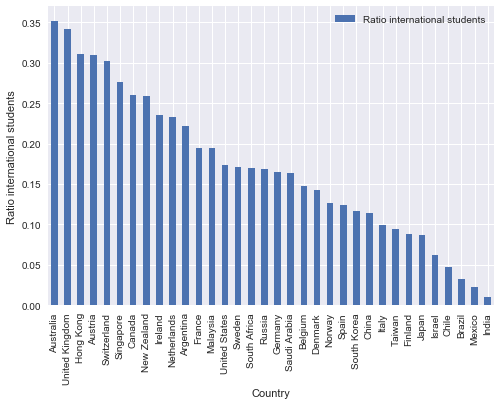

In [269]:
df_tu_QBC = sort(df_tu_country, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBC, country, international_students_ratio, country, international_students_ratio)

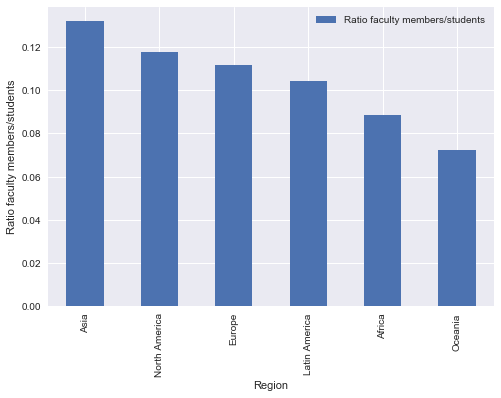

In [272]:
df_tu_region = group(df_tu, region)
df_tu_QAD = sort(df_tu_region, total_faculty_members, total_students, faculty_members_students_ratio).reset_index()
plot(df_tu_QAD, region, faculty_members_students_ratio, region, faculty_members_students_ratio)

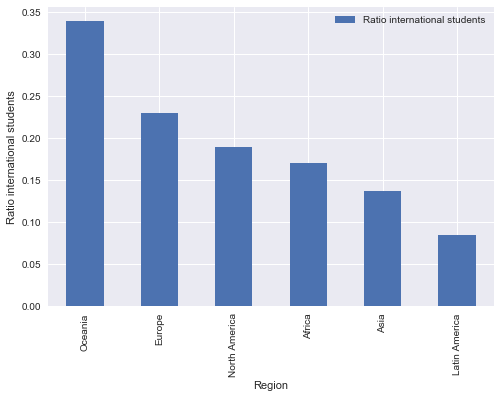

In [273]:
df_tu_QBD = sort(df_tu_region, international_students, total_students, international_students_ratio).reset_index()
plot(df_tu_QBD, region, international_students_ratio, region, international_students_ratio)

## Times Higher Education

In [107]:
def complete_with_tu(name):
    for uni in json_ranking_tu:
        if normalize_name(uni['title']) == name:
            return prepare_uni_data_tu(uni)
def get_missing_uni(df):
    completion = []
    for missing in df[df['Country'].isnull()]['Name']:
        tu_data = complete_with_tu(missing)
        if tu_data:
            tu_data['Rank Time Higher Education'] = int(df[df['Name'] == missing]['Rank Time Higher Education'].values[0])
            completion.append(tu_data)
    return pd.DataFrame(completion)

In [139]:
def get_website_the(url):
    res = get('https://www.timeshighereducation.com'+url)
    soup = bs(res.text, "lxml")
    selection = soup.select('.profile-card__website a')
    if len(selection) == 0:
        return np.nan
    return clean_url(selection[0]['href'])

def prepare_uni_data_the(uni):
    uni_infos = dict()
    uni_infos['Name'] = normalize_name(uni['name'])
    uni_infos['Country'] = uni['location']
    uni_infos['Rank Time Higher Education'] = clean_number(uni['rank'])
    uni_infos['Number of Students'] = clean_number(uni['stats_number_students'])
    uni_infos['Student/Staff Ratio'] = clean_number(uni['stats_student_staff_ratio'])
    uni_infos['% of International Students'] = clean_number(uni['stats_pc_intl_students'])
    uni_infos['url_the'] = get_website_the(uni['url'])
    return uni_infos
res = get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json', 'html')
json_ranking_the = json.loads(res.text)['data']
json_ranking_the = sorted(json_ranking_the, key=lambda k: clean_number(k['rank']))[:200]
df_the = pd.DataFrame(list(map(prepare_uni_data_the,json_ranking_the)))
# # get_missing_uni(df)

In [176]:
#df_the.to_pickle('df_the.xz')
df_the = pd.read_pickle('df_the.xz')
# df = df_tu.merge(df_the, 'outer', on='Name')
# df = get_missing_uni(df).set_index('Name').combine_first(df.set_index('Name'))

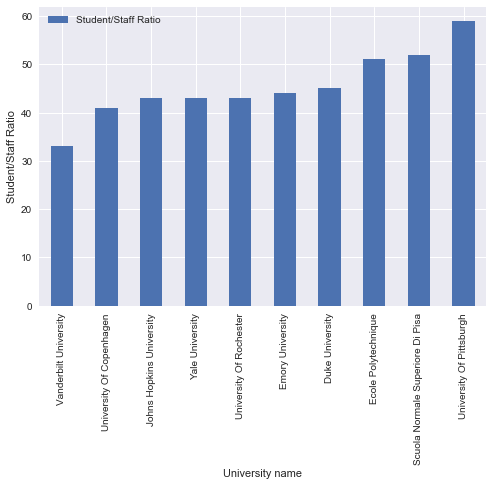

In [284]:
#NOTE! student/staff ratio value are multiplied x10, no difference in sorting
#NOTE! ascending order in student/staff ratio == descending order in staff/student ratio
# and we're looking for staff/student ratio (assuming staff == faculty members)
df_the_QA = df_the.sort_values([students_staff_ratio], ascending=True)
reduced_plot(df_the_QA, name, students_staff_ratio, university_name, students_staff_ratio)

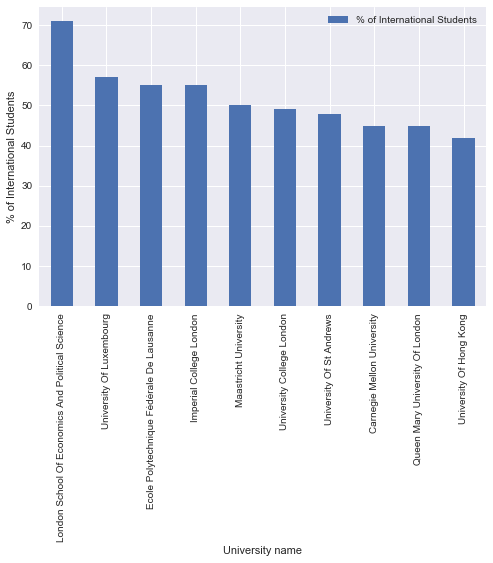

In [311]:
df_the_QB = df_the.sort_values([pc_international_students], ascending=False)
reduced_plot(df_the_QB, name, pc_international_students, university_name, pc_international_students)

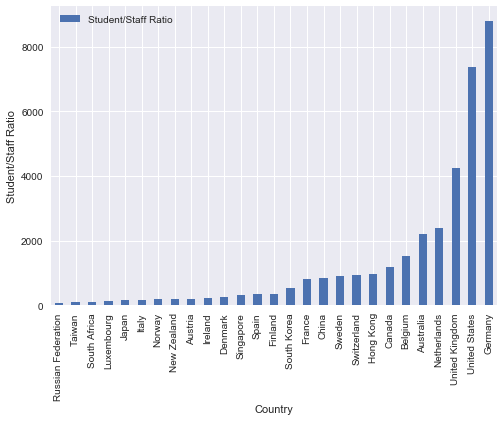

In [310]:
df_the_country = group(df_the, country)
df_the_QAC = df_the_country.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAC, country, students_staff_ratio, country, students_staff_ratio)

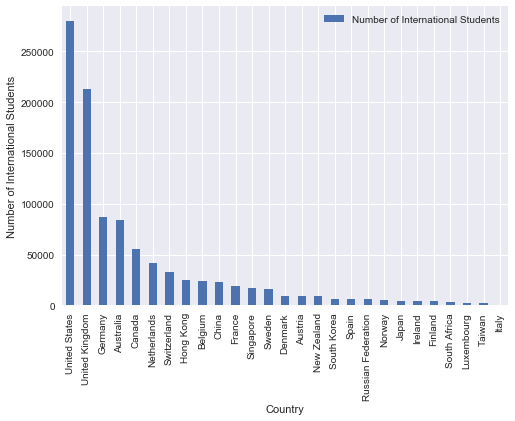

In [309]:
#NOTE i don't use math.ceil() on number of international students because i couldn't implement swiftly.
#less chanches of ties anyway
df_temp = df_the
df_temp[number_international_student] = df_temp[pc_international_students]*df_temp[number_students]/100
df_the_QBC = group(df_temp, country)
df_the_QBC = df_the_QBC.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBC, country, number_international_students, country, number_international_students)

In [299]:
def countryRegionMapping(df_to_map):
    df_with_mapping = df_tu[[country, region]].drop_duplicates()
    df_mapped = df_to_map.merge(df_with_mapping)
    return df_mapped

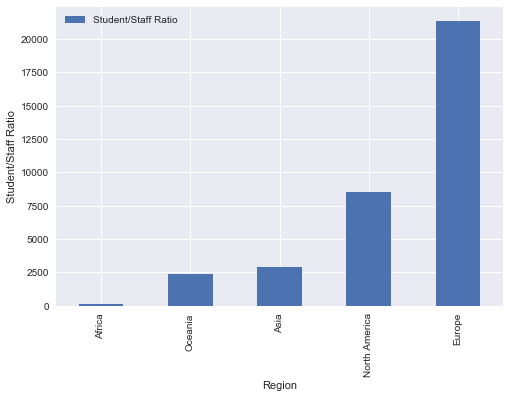

In [308]:
df_mapped = countryRegionMapping(df_the)
df_the_region = group(df_mapped, region)
df_the_QAD = df_the_region.sort_values([students_staff_ratio], ascending=True).reset_index()
plot(df_the_QAD, region, students_staff_ratio, region, students_staff_ratio)

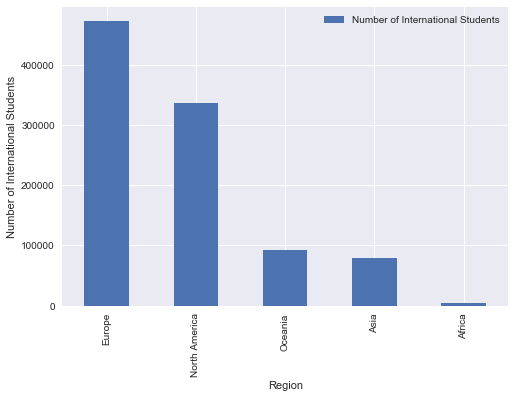

In [307]:
df_mapped = countryRegionMapping(df_temp)
df_the_QBD = group(df_mapped, region)
df_the_QBD = df_the_QBD.sort_values([number_international_students], ascending=False).reset_index()
plot(df_the_QBD, region, number_international_student, region, number_international_student)

In [ ]:
df = df_tu.merge(df_the, 'outer', on=['Name'])
df = get_missing_uni(df).set_index('Name').combine_first(df.set_index('Name'))
# df[df['Country'].isnull()]
# df[df['Name'].str.contains('Gothenburg')]

In [ ]:
df_the